# Wood moisture classification (wmc) model creation pipeline

The following code is adapted from the FP-AI-SENSING1 application of ST microelectronics

In [1]:
import numpy as np
import os
from tqdm import tqdm
import librosa
import librosa.display
import librosa.util
#from IPython.display import Audio
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#import tensorflow as tf
#import keras.utils
#from keras import layers
#from keras import models
#from keras import optimizers
from pickle import dump
import random


import torch
import torch.utils

In [76]:
# Current version (for reproduction)
#print("TensorFlow:", tf.__version__)
#print("Keras:", keras.__version__)
print("Librosa:", librosa.__version__)

Librosa: 0.9.2


## Global settings
__Important:__ These settings have to match the ones in the STM32 application.

In [2]:
AUDIO_SAMPLING_FREQUENCY = 48000 # kHz 
NB_FRAMES = 32 # How many columns for the short time fourier transformation
NB_BINS = 30 # Resolution (bins) of one STFT column
HOP_LENGTH = 512 # Jumps between FFT frames
WINDOW_SIZE = HOP_LENGTH*NB_FRAMES + HOP_LENGTH # For one spectrogram column 1024 samples are needed
NB_WINDOWS = 100 # Total number of windwo recorded in one WAV file
FRAME_SIZE = 1024 # Size for one FFT
FREQ_MIN = 5000 # Lowest bin for the columns
TOP_DB = 80 # Cut off of DBs

## 1. Import and convert the data
Load the files from the data directory. The labels for the files are specified in model/dataset/labels.txt.

In [36]:
dataset_dir = './dataset'
fileset_path = path = os.path.join(dataset_dir, 'labels.txt')
fileset = np.loadtxt(fileset_path, dtype=str)

# 3 classes : 0 dry, 1 semiwet, 2 wet
class_names = ['dry', 'semiwet', 'wet']
labels = {
    'dry' : 0,
    'semiwet' : 1,
    'wet' : 2,
}


# x is a list of the recordings and y is a list of the respective labels (targets)
x = []
y = []

# Iteratate over all recordings defined in labels.txt
for file in tqdm(fileset):
    file_path, file_label = file
    file_path = os.path.join(dataset_dir, file_path)
    
    signal, _ = librosa.load(file_path, sr=AUDIO_SAMPLING_FREQUENCY, mono=True, dtype=np.float32)   
    # Cut off total samples because recording takes a bit more samples
    signal = signal[0:NB_WINDOWS*WINDOW_SIZE]
    
    label = labels[file_label]
    
    x.append(signal)
    y.append(label)

100%|██████████| 18/18 [00:01<00:00, 13.76it/s]


AttributeError: module 'librosa.display' has no attribute 'waveplot'

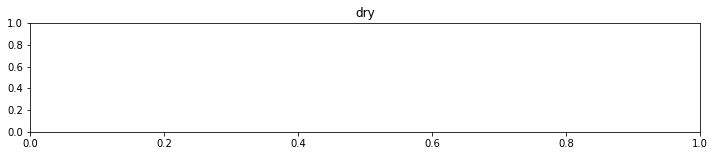

In [79]:
# Check a random sample of first recording
rand = random.randint(0, NB_FRAMES)
recording1 = x[1]
window = recording1[WINDOW_SIZE*rand:WINDOW_SIZE*(rand+1)]

plt.figure(figsize=(12, 2))
plt.title(class_names[y[1]])
librosa.display.waveplot(window, sr=AUDIO_SAMPLING_FREQUENCY)
Audio(window, rate=AUDIO_SAMPLING_FREQUENCY)

## 2. Prepare the data

### 2.1 Slice data into windows
Each audio recording (WAV file) contains the specified number of windows (NB_WINDOWS).

Each window will contain 16,896 samples (32 * 512 + 512) to create a 32 column spectrogram with FRAME_SIZE=1024 and HOP_LENGTH=512.

In [37]:
# Each window will now be an entry in the list
x_windows = []
y_windows = []

# Iteratate over all recordings and create windows
for i in range(len(x)):
    x_tmp = np.asarray(x[i])    
    for k  in range(NB_WINDOWS):
        window = x_tmp[k*WINDOW_SIZE:(k+1)*WINDOW_SIZE]
        x_windows.append(np.transpose(window)) 
    y_windows.append(np.full(NB_WINDOWS, y[i]))
    
# Convert into numpy arrays
x_windows = np.asarray(x_windows)
y_windows = np.asarray(y_windows)

# Reshape labels 
y_windows = y_windows.reshape(y_windows.shape[0]*y_windows.shape[1], )

print("x_windows shape: ", x_windows.shape) # Each window of 16,896 samples can be used to create a spectrogram 
print("y_windows shape: ", y_windows.shape) # Corresponding label for each window


x_windows shape:  (1800, 16896)
y_windows shape:  (1800,)


### 2.3 Standardize features
Standardize features by removing the mean and scaling to unit variance. Save the feature scalers to model/standardize.

In [38]:
'''# Flatten features for scaling
x_features_r = np.reshape(x_features, (len(x_features), NB_BINS * NB_FRAMES))

# Create a feature scaler
scaler = preprocessing.StandardScaler().fit(x_features_r)
mean = scaler.mean_
std = scaler.scale_

#  Save feature scaler
standardize_dir = './standardize/'
np.savetxt(standardize_dir + 'mean.csv', mean.reshape(240, 4),  fmt='%.10e', delimiter=",", newline=",\n")
np.savetxt(standardize_dir + 'std.csv', std.reshape(240, 4),  fmt='%.10e', delimiter=",", newline=",\n")
dump(scaler, open(standardize_dir + 'scaler.pkl', 'wb'))

# Apply the feature scaler 
x_features_s = scaler.transform(x_features_r)

print("x_features_s shape: ", x_features_s.shape)
'''

x_features_s = (x_windows - x_windows.mean()) / x_windows.std()

#x_features_s = x_windows
y_features = y_windows

### 2.4 One hot encoding of labels
Keras requires one hot encoded labels.

In [39]:
def to_categorical(x, n_classes):
    return np.eye(n_classes, dtype='uint8')[x] 

In [40]:
# Convert labels to categorical one-hot encoding
y_features_hot = to_categorical(y_features, n_classes=len(class_names))

print('The shape of the one-hot encoded labels np array is: ' , y_features_hot.shape)

The shape of the one-hot encoded labels np array is:  (1800, 3)


### 2.5 Split data into training, validation and test
Use 25% for testing. The remaining 75% of the features are split in 25% for validation and 75% for training.

In [47]:
#x_train, x_test, y_train, y_test = torch.utils.data.random_split(full_dataset, [train_size, test_size])
x_train, x_test, y_train, y_test = train_test_split(x_features_s,
                                                    y_features_hot,
                                                    test_size=0.25,
                                                    random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=1)

print('Training samples:', x_train.shape)
print('Validation samples:', x_val.shape)
print('Test samples:', x_test.shape)

Training samples: (1012, 16896)
Validation samples: (338, 16896)
Test samples: (450, 16896)


### 2.6 (Optional) Save the features
Save the features to a csv file in a format X-CUBE-AI can understand, that is, for each tensor, the values are in a flattened vector.

In [ ]:
#val_dir = './validation/'
#np.savetxt(val_dir + 'x_train.csv', x_train.reshape(len(x_train), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_train.csv', y_train, delimiter=",")
#np.savetxt(val_dir + 'x_val.csv', x_val.reshape(len(x_val), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_val.csv', y_val, delimiter=",")
#np.savetxt(val_dir + 'x_test.csv', x_test.reshape(len(x_test), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_test.csv', y_test, delimiter=",")

## 3 Model

### 3.1 Create and compile model
Build a sequential convolutional network classifier model

In [42]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [59]:
KERNEL_SIZE = 64
POOL_FACT = 2
STRIDE_FACT = KERNEL_SIZE // 4
CHANNEL_COUNT = 16
use_avg_pool = True
model = torch.nn.Sequential() #1x16896
output_dim = 16896
model.append(torch.nn.Conv1d(in_channels = 1, out_channels = CHANNEL_COUNT, kernel_size = KERNEL_SIZE, stride=STRIDE_FACT)) #16x16896 - 512 + 1 
output_dim = (output_dim - KERNEL_SIZE) // STRIDE_FACT + 1
model.append(torch.nn.ReLU()) 
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Conv1d(in_channels = CHANNEL_COUNT, out_channels=CHANNEL_COUNT, kernel_size=KERNEL_SIZE // 2, stride=STRIDE_FACT // 2)) #16x7681
output_dim = (output_dim - KERNEL_SIZE // 2) // (STRIDE_FACT // 2)+ 1
model.append(torch.nn.ReLU())
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Flatten())
model.append(torch.nn.Linear(in_features = int(output_dim) * CHANNEL_COUNT, out_features = 9))
model.append(torch.nn.ReLU())
model.append(torch.nn.Linear(in_features = 9, out_features = 3))
#model.append(torch.nn.Softmax(-1))

# Print model summary
#model.summary()
print(count_parameters(model))

opt = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

13751


###  3.2 Train the model

In [60]:
# NOTE: pytorch expects channel as second dimension
x_train_r = x_train.reshape(x_train.shape[0], 1, -1)
print(x_train_r.shape)
x_val_r = x_val.reshape(x_val.shape[0], 1, -1)
print(x_val_r.shape)
x_test_r = x_test.reshape(x_test.shape[0], 1, -1)
print(x_test_r.shape)

(1012, 1, 16896)
(338, 1, 16896)
(450, 1, 16896)


In [50]:
def validate(model, criterion, val_input, val_target, device="cpu"):
    output = model(val_input.float().to(device))
    loss = criterion(output, val_target.float().to(device))
    return loss.item()


def train(model, criterion, optimizer, train_input, train_target, val_input, val_target, num_epochs, mini_batch_size, device="cpu"):
    train_input, train_target = train_input.float().to(device), train_target.float().to(device)
    loss_history = {"train_loss":[], "val_loss":[]}
    for e in range(num_epochs):
        print(f"Epoch: {e}")
        avg_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size).float().to(device))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size).float().to(device))
            avg_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            validate_loss = validate(model, criterion, val_input, val_target)
        avg_loss /= (train_input.size(0) // mini_batch_size)
        loss_history["train_loss"].append(avg_loss)
        loss_history["val_loss"].append(validate_loss)
        print("Train Loss:", avg_loss)
        print("Val Loss:", validate_loss)
    return loss_history

In [61]:
# Load a pre-trained model
model.load_state_dict(torch.load("wmc_new.pth"))

<All keys matched successfully>

In [54]:
# Train
history = train(model, criterion, opt, torch.Tensor(x_train_r), torch.Tensor(y_train), torch.Tensor(x_val_r), torch.Tensor(y_val), num_epochs=10, mini_batch_size=x_train_r.shape[0] // 4)

Epoch: 0
Train Loss: 0.030225080205127597
Val Loss: 0.045583974570035934
Epoch: 1
Train Loss: 0.025196765083819628
Val Loss: 0.04077333211898804
Epoch: 2
Train Loss: 0.02290148800238967
Val Loss: 0.04086088016629219
Epoch: 3
Train Loss: 0.019149568397551775
Val Loss: 0.035892583429813385
Epoch: 4
Train Loss: 0.017064259853214025
Val Loss: 0.03842694312334061
Epoch: 5
Train Loss: 0.014611436170525849
Val Loss: 0.03318308666348457
Epoch: 6
Train Loss: 0.012947011273354292
Val Loss: 0.03570898249745369
Epoch: 7
Train Loss: 0.01115629484411329
Val Loss: 0.03192916139960289
Epoch: 8
Train Loss: 0.009921638062223792
Val Loss: 0.03400696441531181
Epoch: 9
Train Loss: 0.00860888441093266
Val Loss: 0.03263142332434654


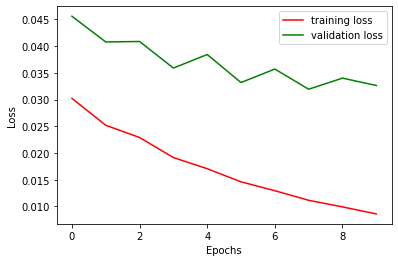

In [58]:
# Plot losses
train_loss = history['train_loss']
val_loss = history['val_loss']

plt.figure()
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(0, len(train_loss)), train_loss, color='r', label='training loss')
plt.plot(np.arange(0, len(val_loss)), val_loss, color='g', label='validation loss')
plt.legend()

### 3.3 Evaluate Accuracy
Compare how the model performs on the test dataset:

In [55]:
# Evaluate the model
def evaluate(model, x_test, y_test):
    y_pred = model(x_test).detach()
    res = np.argmax(y_pred, axis = 1) 
    
    target = np.argmax(y_test, axis = 1)
    train_acc = torch.sum(res == target) / x_test.size(0)

    return train_acc

In [62]:
print('Evaluate model:')
#results = model.evaluate(x_test_r, y_test)
accuracy = evaluate(model, torch.Tensor(x_test_r), torch.Tensor(y_test))
#print('Test loss: {:f}'.format(results[0]))
print('Test accuracy: {:.2f}%'.format(accuracy * 100))

Evaluate model:
Test accuracy: 32.89%


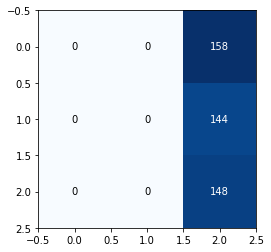

In [63]:
# Plot a confusion matrix
y_pred = model(torch.Tensor(x_test_r)).detach()

y_pred_class_n = np.argmax(y_pred, axis=1)
y_true_class_n = np.argmax(y_test, axis=1)

#accuracy = accuracy_score(y_true_class_n, y_pred_class_n)
#np.set_printoptions(precision=2)
#print("Accuracy = {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(y_true_class_n, y_pred_class_n, labels=[0,1,2])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.imshow(cm, cmap=plt.cm.Blues)

### 3.4 Save the model

In [123]:
# Save the model into an HDF5 file ‘model.h5’
#model.save('wmc.h5')
torch.save(model.state_dict(), 'wmc_new.pth')